In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.8 MB/s eta 0:00:00


In [3]:
df = pd.read_csv('/kaggle/input/heart-rate-time-series-mitbih-database/heart_rate.csv')
df.head()

,T1,T2,T3,T4
0,84.2697,91.4634,60.4839,59.2885
1,84.2697,91.4634,60.4839,59.2885
2,84.0619,91.1834,60.4606,59.2885
3,85.6542,91.8788,60.3391,58.8973
4,87.2093,91.1772,60.0762,58.4359


In [4]:
df

,T1,T2,T3,T4
0,84.2697,91.4634,60.4839,59.2885
1,84.2697,91.4634,60.4839,59.2885
2,84.0619,91.1834,60.4606,59.2885
3,85.6542,91.8788,60.3391,58.8973
4,87.2093,91.1772,60.0762,58.4359
...,...,...,...,...
1795,103.7900,98.6842,NaN,NaN
1796,101.6230,98.6842,NaN,NaN
1797,99.5679,99.0005,NaN,NaN
1798,99.1835,99.3273,NaN,NaN


ADF Statistic: -4.834806010631325
p-value: 4.663358006880067e-05
Critical Values:
    1%: -3.4377022625762232 - Data is stationary
    5%: -2.8647856243940817 - Data is stationary
    10%: -2.568498194061815 - Data is stationary


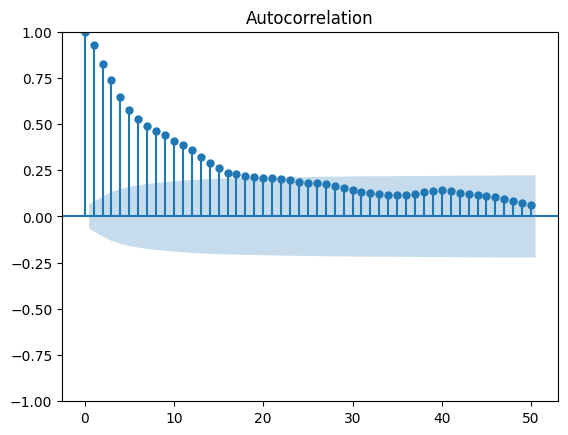

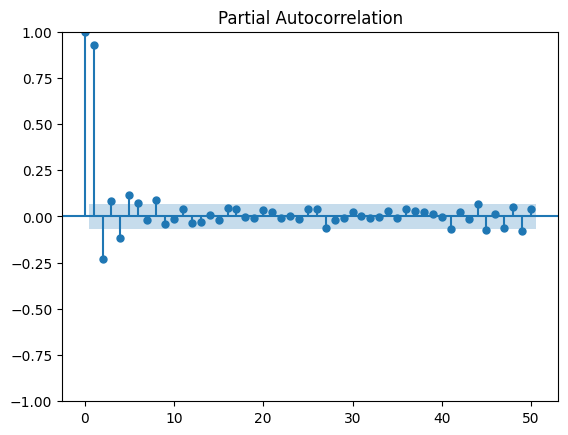

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



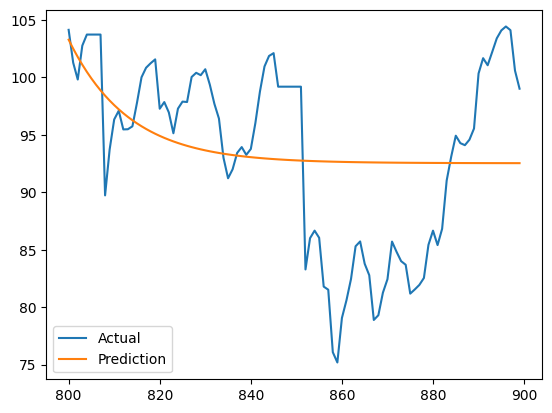

RMSE: 7.299406527635734


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.45817D+00    |proj g|=  1.07839D-02

At iterate    5    f=  4.14490D+00    |proj g|=  7.15021D-04

At iterate   10    f=  3.64172D+00    |proj g|=  6.54712D-02

At iterate   15    f=  2.46027D+00    |proj g|=  8.35161D-01

At iterate   20    f=  2.08586D+00    |proj g|=  7.68372D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     65      1     0     0   8.751D-06   2.086D+00
  F =   2.0858626507917384     

CONVERG

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



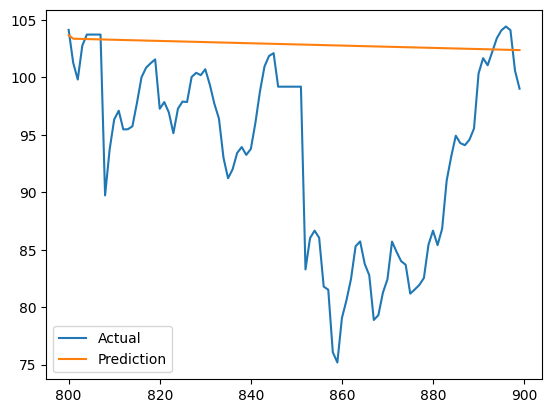

RMSE: 12.216581999148918


2024-06-26 06:52:24.962065: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 06:52:24.962171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 06:52:25.094327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
740/740 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0371
Epoch 2/10
740/740 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0175
Epoch 3/10
740/740 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0079
Epoch 4/10
740/740 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0064
Epoch 5/10
740/740 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0071
Epoch 6/10
740/740 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0065
Epoch 7/10
740/740 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0057
Epoch 8/10
740/740 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0062
Epoch 9/10
740/740 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0086
Epoch 10/10
740/740 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0054
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step


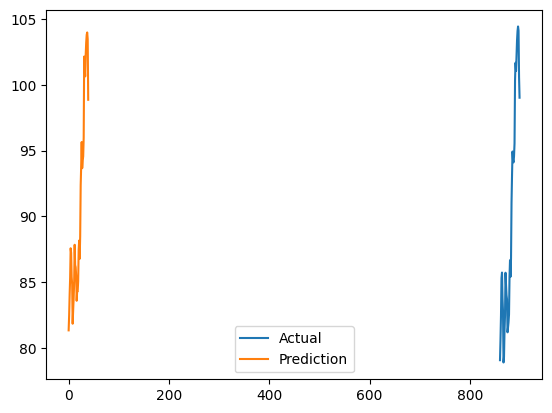

RMSE: 2.1441336939541458


In [5]:
# df terdiri dari 4 kolom yaitu T1, T2, T3, T4 semua adalah hasil pengukuran PPG
# Setiap data adalah hasil pengukuran sinyal PPG selama 0.5 detik
# Kebutuhan data adalah 1 detik
# Jadi kita akan menggabungkan 2 data PPG T1 menjadi 1 data PPG dengan cara mengambil rata-rata dari 2 data tersebut
# Misal di kolom T1, ambil 2 baris pertama dan kedua dijadikan 1 baris kemudian ambil rata-ratanya

df_second = df.copy()
for i in range(0, len(df_second), 2):
    df_second.loc[i] = df_second.loc[i:i+1].mean()

df_second = df_second.drop(df_second.index[1::2])
df_second = df_second.reset_index(drop=True)
df_second

fig = px.line(df_second['T1'], title='PPG Signal', labels={'index':'Time (s)', 'value':'PPG Signal'})
fig.show()

# Total data df_second adalah 900 data/detik = 15 menit
# Sebelumnya kita akan mengecek apakah data stasioner atau tidak
# Kita akan menggunakan Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        if result[0] > value:
            print(f'    {key}: {value} - Data is not stationary')
        else:
            print(f'    {key}: {value} - Data is stationary')

adf_test(df_second['T1'])

# Dari hasil Augmented Dickey-Fuller Test, data PPG stationer
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

# Plot ACF dan PACF
plot_acf(df_second['T1'], lags=50)
plt.show()

plot_pacf(df_second['T1'], lags=50)
plt.show()

# Dari plot ACF dan PACF, kita akan menggunakan ARIMA(1,0,0)
train = df_second['T1'][:800]
test = df_second['T1'][800:]

# Membuat model ARIMA
model = ARIMA(train, order=(1,0,0))
model_fit = model.fit()
model_fit.summary()

# Prediksi data testing
start = len(train)
end = len(train) + len(test) - 1
pred = model_fit.predict(start=start, end=end, typ='levels')

# Plot hasil prediksi
plt.plot(test, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()
plt.show()

# Menghitung nilai RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, pred))
print(f'RMSE: {rmse}')

# Dari hasil prediksi, RMSE yang didapat adalah 7.299406529109165
# Nilai RMSE yang didapat cukup tinggi, kita akan mencoba menggunakan model SARIMA
# Kita akan mencari nilai p, d, dan q yang optimal
# Kita akan menggunakan Auto ARIMA
from pmdarima import auto_arima

auto_model = auto_arima(train, seasonal=True, m=2)
auto_model.summary()

# Dari hasil Auto ARIMA, model SARIMAX(0, 0, 1)x(1, 0, 1, 2) adalah model yang optimal
# Kita akan membuat model SARIMAX
model_sarima = SARIMAX(train, order=(0,0,1), seasonal_order=(1,0,1,2))
model_sarima_fit = model_sarima.fit()
model_sarima_fit.summary()

# Prediksi data testing
pred_sarima = model_sarima_fit.predict(start=start, end=end, typ='levels')

# Plot hasil prediksi
plt.plot(test, label='Actual')
plt.plot(pred_sarima, label='Prediction')
plt.legend()
plt.show()

# Menghitung nilai RMSE
rmse_sarima = np.sqrt(mean_squared_error(test, pred_sarima))
print(f'RMSE: {rmse_sarima}')

# Dari hasil prediksi, RMSE yang didapat adalah 12.272878651484277
# Nilai RMSE yang didapat cukup tinggi, kita akan mencoba menggunakan model lain yaitu LSTM
# Kita akan menggunakan LSTM untuk memodelkan data PPG
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import numpy as np

# Normalisasi data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))

time_step = 60
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data)-time_step):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_scaled, time_step)

# Reshape data untuk LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Membuat model LSTM sederhana
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Latih model
model_lstm.fit(X_train, y_train, epochs=10, batch_size=1)

# Membuat data testing
test_scaled = scaler.transform(test.values.reshape(-1, 1))
X_test, y_test = create_dataset(test_scaled, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Prediksi data testing
pred_lstm = model_lstm.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_lstm)

# Plot hasil prediksi
plt.plot(test[time_step:], label='Actual')
plt.plot(pred_lstm, label='Prediction')
plt.legend()
plt.show()

# Menghitung nilai RMSE
test_adjusted = test[time_step:].reset_index(drop=True)
pred_lstm_adjusted = pred_lstm.flatten()
rmse_lstm = np.sqrt(mean_squared_error(test_adjusted, pred_lstm_adjusted))
print(f'RMSE: {rmse_lstm}')

  0%|          | 0/900 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044


  0%|          | 1/900 [00:01<15:57,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|          | 3/900 [00:01<04:54,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 5/900 [00:01<02:52,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 7/900 [00:01<02:04,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|          | 9/900 [00:01<01:40,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052


  1%|          | 11/900 [00:02<03:59,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  1%|▏         | 13/900 [00:02<03:01,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 15/900 [00:03<02:24,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  2%|▏         | 17/900 [00:03<02:00,  7.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|▏         | 19/900 [00:03<01:41,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0213


  2%|▏         | 21/900 [00:04<04:27,  3.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  3%|▎         | 23/900 [00:04<03:24,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|▎         | 25/900 [00:05<02:40,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 27/900 [00:05<02:09,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|▎         | 29/900 [00:05<01:49,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080


  3%|▎         | 31/900 [00:06<04:27,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  4%|▎         | 33/900 [00:06<03:26,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▍         | 35/900 [00:07<02:41,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  4%|▍         | 37/900 [00:07<02:10,  6.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|▍         | 39/900 [00:07<01:47,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077


  5%|▍         | 41/900 [00:08<03:37,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▍         | 43/900 [00:08<02:50,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|▌         | 45/900 [00:08<02:16,  6.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▌         | 47/900 [00:08<01:51,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|▌         | 49/900 [00:09<01:34,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055


  6%|▌         | 51/900 [00:10<04:12,  3.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|▌         | 53/900 [00:10<03:13,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▌         | 55/900 [00:10<02:32,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|▋         | 57/900 [00:10<02:03,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|▋         | 59/900 [00:11<01:44,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0309
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036


  7%|▋         | 61/900 [00:12<04:16,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 63/900 [00:12<03:16,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  7%|▋         | 65/900 [00:12<02:34,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|▋         | 67/900 [00:12<02:05,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  8%|▊         | 69/900 [00:13<01:45,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075


  8%|▊         | 71/900 [00:14<03:34,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|▊         | 73/900 [00:14<02:47,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  8%|▊         | 75/900 [00:14<02:15,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|▊         | 77/900 [00:14<01:52,  7.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  9%|▉         | 79/900 [00:14<01:35,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080


  9%|▉         | 81/900 [00:15<03:25,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|▉         | 83/900 [00:15<02:39,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|▉         | 85/900 [00:16<02:07,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 10%|▉         | 87/900 [00:16<01:47,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|▉         | 89/900 [00:16<01:32,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0094
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0300


 10%|█         | 91/900 [00:17<03:21,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|█         | 93/900 [00:17<02:36,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|█         | 95/900 [00:17<02:06,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|█         | 97/900 [00:17<01:44,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|█         | 99/900 [00:18<01:30,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029


 11%|█         | 101/900 [00:19<03:58,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|█▏        | 103/900 [00:19<03:03,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|█▏        | 105/900 [00:19<02:24,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|█▏        | 107/900 [00:19<01:58,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 109/900 [00:20<01:39,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057


 12%|█▏        | 111/900 [00:21<03:21,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|█▎        | 113/900 [00:21<02:37,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|█▎        | 115/900 [00:21<02:06,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█▎        | 117/900 [00:21<01:43,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|█▎        | 119/900 [00:21<01:29,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075


 13%|█▎        | 121/900 [00:23<03:54,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|█▎        | 123/900 [00:23<03:00,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 14%|█▍        | 125/900 [00:23<02:23,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 14%|█▍        | 127/900 [00:23<01:57,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 129/900 [00:23<01:38,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0039
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097


 15%|█▍        | 131/900 [00:25<03:59,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▍        | 133/900 [00:25<03:04,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 15%|█▌        | 135/900 [00:25<02:24,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|█▌        | 137/900 [00:25<01:56,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|█▌        | 139/900 [00:25<01:36,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114


 16%|█▌        | 141/900 [00:27<03:13,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 143/900 [00:27<02:31,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|█▌        | 145/900 [00:27<02:00,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 16%|█▋        | 147/900 [00:27<01:39,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█▋        | 149/900 [00:27<01:24,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0063
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039


 17%|█▋        | 151/900 [00:29<03:46,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 153/900 [00:29<02:54,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|█▋        | 155/900 [00:29<02:18,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█▋        | 157/900 [00:29<01:52,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 159/900 [00:29<01:34,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0057
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059


 18%|█▊        | 161/900 [00:30<03:11,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█▊        | 163/900 [00:30<02:29,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█▊        | 165/900 [00:31<01:59,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▊        | 167/900 [00:31<01:37,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|█▉        | 169/900 [00:31<01:23,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0098
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042


 19%|█▉        | 171/900 [00:32<03:37,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 19%|█▉        | 173/900 [00:32<02:47,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|█▉        | 175/900 [00:33<02:12,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|█▉        | 177/900 [00:33<01:47,  6.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|█▉        | 179/900 [00:33<01:29,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028


 20%|██        | 181/900 [00:34<03:40,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 20%|██        | 183/900 [00:34<02:49,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 21%|██        | 185/900 [00:35<02:14,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 21%|██        | 187/900 [00:35<01:48,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██        | 189/900 [00:35<01:30,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049


 21%|██        | 191/900 [00:36<03:38,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|██▏       | 193/900 [00:36<02:46,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|██▏       | 195/900 [00:37<02:12,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 22%|██▏       | 197/900 [00:37<01:48,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 199/900 [00:37<01:30,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048


 22%|██▏       | 201/900 [00:38<03:37,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|██▎       | 203/900 [00:39<02:46,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 205/900 [00:39<02:10,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 23%|██▎       | 207/900 [00:39<01:45,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██▎       | 209/900 [00:39<01:28,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0103
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058


 23%|██▎       | 211/900 [00:40<02:58,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|██▎       | 213/900 [00:40<02:19,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|██▍       | 215/900 [00:40<01:51,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|██▍       | 217/900 [00:40<01:31,  7.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|██▍       | 219/900 [00:41<01:18,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111


 25%|██▍       | 221/900 [00:42<02:50,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|██▍       | 223/900 [00:42<02:12,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|██▌       | 225/900 [00:42<01:46,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|██▌       | 227/900 [00:42<01:27,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 25%|██▌       | 229/900 [00:42<01:14,  8.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060


 26%|██▌       | 231/900 [00:44<03:20,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 26%|██▌       | 233/900 [00:44<02:36,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▌       | 235/900 [00:44<02:04,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▋       | 237/900 [00:44<01:41,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 239/900 [00:44<01:24,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073


 27%|██▋       | 241/900 [00:46<02:50,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 243/900 [00:46<02:13,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██▋       | 245/900 [00:46<01:46,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 27%|██▋       | 247/900 [00:46<01:28,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|██▊       | 249/900 [00:46<01:15,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045


 28%|██▊       | 251/900 [00:48<03:16,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|██▊       | 253/900 [00:48<02:31,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|██▊       | 255/900 [00:48<01:59,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▊       | 257/900 [00:48<01:36,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|██▉       | 259/900 [00:48<01:20,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057


 29%|██▉       | 261/900 [00:50<03:16,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 263/900 [00:50<02:30,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|██▉       | 265/900 [00:50<01:58,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 30%|██▉       | 267/900 [00:50<01:36,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|██▉       | 269/900 [00:50<01:20,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0106
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067


 30%|███       | 271/900 [00:51<02:41,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 30%|███       | 273/900 [00:51<02:07,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 275/900 [00:52<01:42,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|███       | 277/900 [00:52<01:24,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███       | 279/900 [00:52<01:12,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055


 31%|███       | 281/900 [00:53<02:35,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 31%|███▏      | 283/900 [00:53<02:02,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 32%|███▏      | 285/900 [00:53<01:38,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 287/900 [00:53<01:22,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 32%|███▏      | 289/900 [00:54<01:11,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0059
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048


 32%|███▏      | 291/900 [00:55<02:35,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|███▎      | 293/900 [00:55<02:00,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|███▎      | 295/900 [00:55<01:37,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|███▎      | 297/900 [00:55<01:21,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|███▎      | 299/900 [00:55<01:09,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0122


 33%|███▎      | 301/900 [00:56<02:30,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|███▎      | 303/900 [00:57<01:57,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 305/900 [00:57<01:34,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 307/900 [00:57<01:18,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 34%|███▍      | 309/900 [00:57<01:06,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0092


 35%|███▍      | 311/900 [00:58<02:28,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|███▍      | 313/900 [00:58<01:56,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 35%|███▌      | 315/900 [00:58<01:34,  6.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 35%|███▌      | 317/900 [00:59<01:22,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 35%|███▌      | 319/900 [00:59<01:11,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0054
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062


 36%|███▌      | 321/900 [01:00<03:02,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▌      | 323/900 [01:00<02:20,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▌      | 325/900 [01:01<01:50,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▋      | 327/900 [01:01<01:29,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 37%|███▋      | 329/900 [01:01<01:14,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0145


 37%|███▋      | 331/900 [01:02<02:29,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 37%|███▋      | 333/900 [01:02<01:56,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 37%|███▋      | 335/900 [01:02<01:32,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|███▋      | 337/900 [01:02<01:16,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 339/900 [01:03<01:05,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071


 38%|███▊      | 341/900 [01:04<02:48,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 343/900 [01:04<02:09,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 38%|███▊      | 345/900 [01:04<01:42,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▊      | 347/900 [01:04<01:22,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 39%|███▉      | 349/900 [01:05<01:09,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052


 39%|███▉      | 351/900 [01:06<02:50,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|███▉      | 353/900 [01:06<02:10,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|███▉      | 355/900 [01:06<01:41,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|███▉      | 357/900 [01:07<01:21,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|███▉      | 359/900 [01:07<01:08,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085


 40%|████      | 361/900 [01:08<02:19,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 40%|████      | 363/900 [01:08<01:48,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|████      | 365/900 [01:08<01:26,  6.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████      | 367/900 [01:08<01:11,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|████      | 369/900 [01:08<01:00,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060


 41%|████      | 371/900 [01:09<02:11,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 41%|████▏     | 373/900 [01:10<01:43,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 375/900 [01:10<01:24,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 42%|████▏     | 377/900 [01:10<01:09,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 42%|████▏     | 379/900 [01:10<00:58,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080


 42%|████▏     | 381/900 [01:12<02:35,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 43%|████▎     | 383/900 [01:12<02:00,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 43%|████▎     | 385/900 [01:12<01:35,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 387/900 [01:12<01:17,  6.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|████▎     | 389/900 [01:12<01:04,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053


 43%|████▎     | 391/900 [01:13<02:11,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 44%|████▎     | 393/900 [01:13<01:42,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 44%|████▍     | 395/900 [01:14<01:22,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 44%|████▍     | 397/900 [01:14<01:08,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|████▍     | 399/900 [01:14<00:59,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0106


 45%|████▍     | 401/900 [01:15<02:05,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 45%|████▍     | 403/900 [01:15<01:38,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 45%|████▌     | 405/900 [01:15<01:19,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 45%|████▌     | 407/900 [01:15<01:05,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████▌     | 409/900 [01:15<00:56,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056


 46%|████▌     | 411/900 [01:17<02:26,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 46%|████▌     | 413/900 [01:17<01:52,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 46%|████▌     | 415/900 [01:17<01:29,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 46%|████▋     | 417/900 [01:17<01:12,  6.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 47%|████▋     | 419/900 [01:18<01:00,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0094
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0130


 47%|████▋     | 421/900 [01:19<02:02,  3.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 47%|████▋     | 423/900 [01:19<01:35,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 47%|████▋     | 425/900 [01:19<01:16,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 47%|████▋     | 427/900 [01:19<01:04,  7.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 48%|████▊     | 429/900 [01:19<00:54,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050


 48%|████▊     | 431/900 [01:21<02:20,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|████▊     | 433/900 [01:21<01:47,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|████▊     | 435/900 [01:21<01:24,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 49%|████▊     | 437/900 [01:21<01:08,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 49%|████▉     | 439/900 [01:21<00:58,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067


 49%|████▉     | 441/900 [01:22<01:59,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 49%|████▉     | 443/900 [01:23<01:32,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 49%|████▉     | 445/900 [01:23<01:14,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|████▉     | 447/900 [01:23<01:01,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 50%|████▉     | 449/900 [01:23<00:52,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0087


 50%|█████     | 451/900 [01:24<01:57,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 50%|█████     | 453/900 [01:24<01:30,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████     | 455/900 [01:24<01:12,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 51%|█████     | 457/900 [01:25<00:59,  7.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 51%|█████     | 459/900 [01:25<00:51,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060


 51%|█████     | 461/900 [01:26<01:51,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████▏    | 463/900 [01:26<01:26,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 52%|█████▏    | 465/900 [01:26<01:09,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|█████▏    | 467/900 [01:26<00:56,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 52%|█████▏    | 469/900 [01:26<00:48,  8.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0093
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0115


 52%|█████▏    | 471/900 [01:28<02:08,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 473/900 [01:28<01:38,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 475/900 [01:28<01:17,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|█████▎    | 477/900 [01:28<01:02,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|█████▎    | 479/900 [01:28<00:52,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071


 53%|█████▎    | 481/900 [01:30<01:47,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|█████▎    | 483/900 [01:30<01:24,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▍    | 485/900 [01:30<01:09,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|█████▍    | 487/900 [01:30<00:57,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 54%|█████▍    | 489/900 [01:30<00:52,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0097
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079


 55%|█████▍    | 491/900 [01:32<02:12,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 55%|█████▍    | 493/900 [01:32<01:41,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 55%|█████▌    | 495/900 [01:32<01:20,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 55%|█████▌    | 497/900 [01:32<01:03,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 55%|█████▌    | 499/900 [01:32<00:53,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059


 56%|█████▌    | 501/900 [01:34<01:44,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 56%|█████▌    | 503/900 [01:34<01:21,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 56%|█████▌    | 505/900 [01:34<01:06,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▋    | 507/900 [01:34<00:56,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|█████▋    | 509/900 [01:34<00:47,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096


 57%|█████▋    | 511/900 [01:35<01:37,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 57%|█████▋    | 513/900 [01:35<01:16,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 57%|█████▋    | 515/900 [01:36<01:02,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 57%|█████▋    | 517/900 [01:36<00:51,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 519/900 [01:36<00:44,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057


 58%|█████▊    | 521/900 [01:37<01:34,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 58%|█████▊    | 523/900 [01:37<01:14,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|█████▊    | 525/900 [01:37<00:59,  6.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 59%|█████▊    | 527/900 [01:37<00:50,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 59%|█████▉    | 529/900 [01:38<00:43,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0157


 59%|█████▉    | 531/900 [01:39<01:51,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████▉    | 533/900 [01:39<01:26,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████▉    | 535/900 [01:39<01:08,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 60%|█████▉    | 537/900 [01:39<00:55,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|█████▉    | 539/900 [01:40<00:46,  7.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053


 60%|██████    | 541/900 [01:41<01:51,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████    | 543/900 [01:41<01:25,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 61%|██████    | 545/900 [01:41<01:06,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|██████    | 547/900 [01:42<00:54,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 61%|██████    | 549/900 [01:42<00:45,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073


 61%|██████    | 551/900 [01:43<01:29,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|██████▏   | 553/900 [01:43<01:09,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|██████▏   | 555/900 [01:43<00:55,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 62%|██████▏   | 557/900 [01:43<00:46,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 62%|██████▏   | 559/900 [01:43<00:39,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0057
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071


 62%|██████▏   | 561/900 [01:45<01:27,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|██████▎   | 563/900 [01:45<01:08,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 63%|██████▎   | 565/900 [01:45<00:54,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|██████▎   | 567/900 [01:45<00:45,  7.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|██████▎   | 569/900 [01:45<00:38,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082


 63%|██████▎   | 571/900 [01:46<01:22,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████▎   | 573/900 [01:46<01:04,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|██████▍   | 575/900 [01:46<00:51,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 64%|██████▍   | 577/900 [01:47<00:42,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 64%|██████▍   | 579/900 [01:47<00:36,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056


 65%|██████▍   | 581/900 [01:48<01:20,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▍   | 583/900 [01:48<01:03,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|██████▌   | 585/900 [01:48<00:50,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████▌   | 587/900 [01:48<00:41,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▌   | 589/900 [01:48<00:35,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0162


 66%|██████▌   | 591/900 [01:50<01:32,  3.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|██████▌   | 593/900 [01:50<01:11,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|██████▌   | 595/900 [01:50<00:55,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|██████▋   | 597/900 [01:50<00:44,  6.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|██████▋   | 599/900 [01:51<00:37,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029


 67%|██████▋   | 601/900 [01:52<01:31,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|██████▋   | 603/900 [01:52<01:10,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|██████▋   | 605/900 [01:52<00:55,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|██████▋   | 607/900 [01:52<00:44,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 609/900 [01:53<00:37,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068


 68%|██████▊   | 611/900 [01:54<01:29,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|██████▊   | 613/900 [01:54<01:08,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 68%|██████▊   | 615/900 [01:54<00:53,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 69%|██████▊   | 617/900 [01:54<00:43,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 69%|██████▉   | 619/900 [01:55<00:35,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0122


 69%|██████▉   | 621/900 [01:56<01:12,  3.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 69%|██████▉   | 623/900 [01:56<00:56,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 69%|██████▉   | 625/900 [01:56<00:45,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 70%|██████▉   | 627/900 [01:56<00:37,  7.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|██████▉   | 629/900 [01:56<00:32,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075


 70%|███████   | 631/900 [01:57<01:07,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 70%|███████   | 633/900 [01:58<00:53,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 71%|███████   | 635/900 [01:58<00:42,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 71%|███████   | 637/900 [01:58<00:35,  7.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|███████   | 639/900 [01:58<00:29,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0169
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0119


 71%|███████   | 641/900 [01:59<01:17,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 71%|███████▏  | 643/900 [02:00<00:59,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 72%|███████▏  | 645/900 [02:00<00:47,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|███████▏  | 647/900 [02:00<00:38,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 72%|███████▏  | 649/900 [02:00<00:32,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0064


 72%|███████▏  | 651/900 [02:01<01:06,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|███████▎  | 653/900 [02:01<00:51,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 73%|███████▎  | 655/900 [02:02<00:41,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|███████▎  | 657/900 [02:02<00:34,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 73%|███████▎  | 659/900 [02:02<00:29,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072


 73%|███████▎  | 661/900 [02:03<01:13,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████▎  | 663/900 [02:03<00:55,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 74%|███████▍  | 665/900 [02:04<00:43,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 74%|███████▍  | 667/900 [02:04<00:35,  6.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████▍  | 669/900 [02:04<00:29,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080


 75%|███████▍  | 671/900 [02:05<01:11,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|███████▍  | 673/900 [02:06<00:54,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|███████▌  | 675/900 [02:06<00:42,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 75%|███████▌  | 677/900 [02:06<00:34,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 75%|███████▌  | 679/900 [02:06<00:29,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050


 76%|███████▌  | 681/900 [02:07<00:56,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|███████▌  | 683/900 [02:07<00:44,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 76%|███████▌  | 685/900 [02:07<00:34,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 76%|███████▋  | 687/900 [02:08<00:28,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 77%|███████▋  | 689/900 [02:08<00:24,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063


 77%|███████▋  | 691/900 [02:09<00:53,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 693/900 [02:09<00:41,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|███████▋  | 695/900 [02:09<00:33,  6.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████▋  | 697/900 [02:09<00:27,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 78%|███████▊  | 699/900 [02:09<00:24,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0108
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074


 78%|███████▊  | 701/900 [02:11<00:51,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 78%|███████▊  | 703/900 [02:11<00:39,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 78%|███████▊  | 705/900 [02:11<00:31,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|███████▊  | 707/900 [02:11<00:26,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 79%|███████▉  | 709/900 [02:11<00:22,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064


 79%|███████▉  | 711/900 [02:12<00:48,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|███████▉  | 713/900 [02:12<00:37,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|███████▉  | 715/900 [02:13<00:29,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 80%|███████▉  | 717/900 [02:13<00:24,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|███████▉  | 719/900 [02:13<00:20,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061


 80%|████████  | 721/900 [02:14<00:54,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|████████  | 723/900 [02:15<00:41,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 81%|████████  | 725/900 [02:15<00:32,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 81%|████████  | 727/900 [02:15<00:26,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 81%|████████  | 729/900 [02:15<00:21,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110


 81%|████████  | 731/900 [02:16<00:44,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 81%|████████▏ | 733/900 [02:16<00:34,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 82%|████████▏ | 735/900 [02:16<00:27,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 82%|████████▏ | 737/900 [02:17<00:22,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|████████▏ | 739/900 [02:17<00:18,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0199
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052


 82%|████████▏ | 741/900 [02:18<00:48,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 743/900 [02:18<00:36,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 745/900 [02:18<00:28,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 83%|████████▎ | 747/900 [02:19<00:23,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 83%|████████▎ | 749/900 [02:19<00:19,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068


 83%|████████▎ | 751/900 [02:20<00:38,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 84%|████████▎ | 753/900 [02:20<00:30,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 84%|████████▍ | 755/900 [02:20<00:23,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 84%|████████▍ | 757/900 [02:20<00:19,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|████████▍ | 759/900 [02:20<00:16,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0236
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0086


 85%|████████▍ | 761/900 [02:22<00:34,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|████████▍ | 763/900 [02:22<00:26,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|████████▌ | 765/900 [02:22<00:28,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|████████▌ | 767/900 [02:22<00:22,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 85%|████████▌ | 769/900 [02:22<00:18,  7.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0107
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083


 86%|████████▌ | 771/900 [02:24<00:33,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▌ | 773/900 [02:24<00:26,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 86%|████████▌ | 775/900 [02:24<00:20,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|████████▋ | 777/900 [02:24<00:17,  6.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 87%|████████▋ | 779/900 [02:24<00:15,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0134
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0224


 87%|████████▋ | 781/900 [02:25<00:30,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████▋ | 783/900 [02:25<00:23,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████▋ | 785/900 [02:26<00:18,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 87%|████████▋ | 787/900 [02:26<00:15,  7.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 88%|████████▊ | 789/900 [02:26<00:13,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0135
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065


 88%|████████▊ | 791/900 [02:27<00:27,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 88%|████████▊ | 793/900 [02:27<00:20,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|████████▊ | 795/900 [02:27<00:16,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▊ | 797/900 [02:27<00:13,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 799/900 [02:28<00:11,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0174
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110


 89%|████████▉ | 801/900 [02:29<00:29,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 803/900 [02:29<00:22,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|████████▉ | 805/900 [02:29<00:17,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|████████▉ | 807/900 [02:30<00:14,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|████████▉ | 809/900 [02:30<00:11,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0119
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0208


 90%|█████████ | 811/900 [02:31<00:27,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|█████████ | 813/900 [02:31<00:20,  4.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 91%|█████████ | 815/900 [02:31<00:16,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 91%|█████████ | 817/900 [02:32<00:12,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 91%|█████████ | 819/900 [02:32<00:10,  7.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0030
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0072


 91%|█████████ | 821/900 [02:33<00:24,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 91%|█████████▏| 823/900 [02:33<00:18,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 92%|█████████▏| 825/900 [02:34<00:14,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 92%|█████████▏| 827/900 [02:34<00:11,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 92%|█████████▏| 829/900 [02:34<00:09,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0097


 92%|█████████▏| 831/900 [02:35<00:18,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 93%|█████████▎| 833/900 [02:35<00:14,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 93%|█████████▎| 835/900 [02:35<00:10,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 93%|█████████▎| 837/900 [02:35<00:08,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 93%|█████████▎| 839/900 [02:36<00:07,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0231
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053


 93%|█████████▎| 841/900 [02:37<00:18,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 94%|█████████▎| 843/900 [02:37<00:13,  4.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 94%|█████████▍| 845/900 [02:37<00:10,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 94%|█████████▍| 847/900 [02:38<00:08,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|█████████▍| 849/900 [02:38<00:06,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085


 95%|█████████▍| 851/900 [02:39<00:15,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▍| 853/900 [02:39<00:11,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 95%|█████████▌| 855/900 [02:39<00:08,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 95%|█████████▌| 857/900 [02:40<00:06,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|█████████▌| 859/900 [02:40<00:05,  7.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0125
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061


 96%|█████████▌| 861/900 [02:41<00:10,  3.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 96%|█████████▌| 863/900 [02:41<00:07,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 96%|█████████▌| 865/900 [02:41<00:05,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████▋| 867/900 [02:41<00:04,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████▋| 869/900 [02:41<00:03,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054


 97%|█████████▋| 871/900 [02:43<00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 97%|█████████▋| 873/900 [02:43<00:05,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 97%|█████████▋| 875/900 [02:43<00:04,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 97%|█████████▋| 877/900 [02:43<00:03,  7.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 879/900 [02:43<00:02,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0095
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0133


 98%|█████████▊| 881/900 [02:45<00:05,  3.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 883/900 [02:45<00:03,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 98%|█████████▊| 885/900 [02:45<00:02,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 99%|█████████▊| 887/900 [02:45<00:01,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 99%|█████████▉| 889/900 [02:45<00:01,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 1/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0100
Epoch 2/2
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0118


 99%|█████████▉| 891/900 [02:47<00:02,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 99%|█████████▉| 893/900 [02:47<00:01,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 99%|█████████▉| 895/900 [02:47<00:00,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|█████████▉| 897/900 [02:47<00:00,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


100%|█████████▉| 899/900 [02:47<00:00,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


100%|██████████| 900/900 [02:47<00:00,  5.36it/s]
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



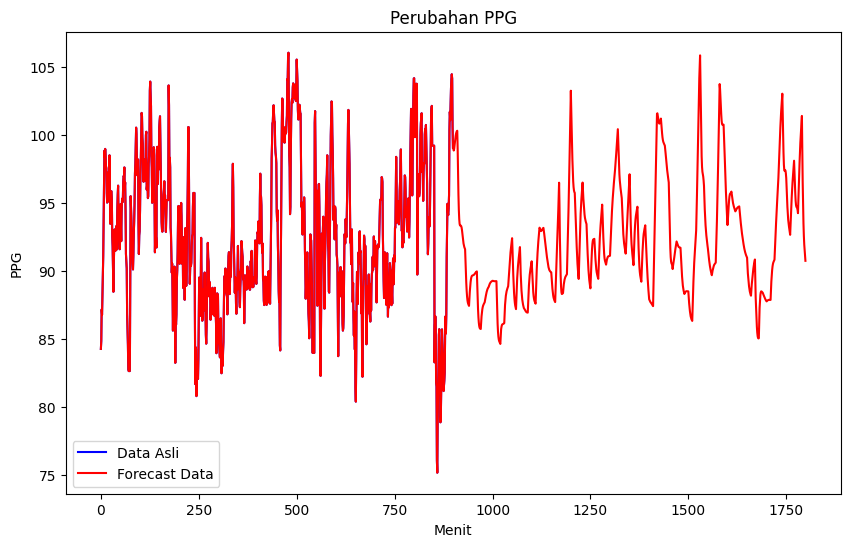

In [6]:
from tqdm import tqdm
last_data = df_second['T1'][-time_step:]
last_data_scaled = scaler.transform(last_data.values.reshape(-1, 1))
X_last_data = last_data_scaled.reshape(1, time_step, 1)

pred_future2 = []
for i in tqdm(range(900)): 
    pred = model_lstm.predict(X_last_data)
    pred_future2.append(pred[0][0])
    last_data_scaled = np.append(last_data_scaled, pred)
    last_data_scaled = last_data_scaled[1:]
    X_last_data = last_data_scaled.reshape(1, time_step, 1)
    if i % 10 == 0:
        train_scaled = np.append(train_scaled, pred.flatten())
        train_scaled_2d = train_scaled.reshape(-1, 1)
        X_train, y_train = create_dataset(train_scaled_2d, time_step)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        model_lstm.fit(X_train, y_train, epochs=2, batch_size=1, steps_per_epoch=50)
        
pred_future2 = scaler.inverse_transform(np.array(pred_future2).reshape(-1, 1)).flatten()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_second['T1'], color='blue', label='Data Asli')
sns.lineplot(data=list(df_second['T1']) + list(pred_future2), color='red', label='Forecast Data')
plt.title('Perubahan PPG')
plt.xlabel('Menit')
plt.ylabel('PPG')
plt.show()